In [3]:
import seml
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

In [4]:
%load_ext autoreload
%autoreload 2

In [27]:
seml_results = seml.get_results('rgnn_rpprgo_papers100M', to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])

In [12]:
seml_results2 = seml.get_results('rgnn_pprgo_cora_citeseer', to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])


In [14]:
seml_results_orig = seml_results.copy()

In [15]:
seml_results = seml_results_orig.copy()

In [16]:
len(seml_results)

5920

In [9]:
relevant_columns = [#'_id', 
       'config.model_params.label',
       'config.model_params.model',
       'config.dataset', 
       'config.seed',
        #'config.model_params.batch_norm',
        'config.model_params.mean',
       'result.accuracy',
        'config.model_params.hidden_size',
        'config.model_params.nlayers',
       #'config.model_params.n_filters',
       #'config.model_params.gdc_params', 
       #'config.model_params.svd_params',
       #'config.model_params.jaccard_params',
        'config.model_params.dropout', 
        'config.model_params.alpha',
        'config.model_params.eps',
        'config.model_params.topk', 
       'config.model_params.mean_kwargs.temperature',
       #'config.model_params.mean_kwargs.k',
       #'config.model_params.mean_kwargs.with_weight_correction',
       #'config.model_params.do_cache_adj_prep', 
       #"config.normalize",
       'config.model_params.ppr_normalization',
       'config.train_params.lr',
       'config.train_params.weight_decay', 'config.train_params.patience',
       'config.train_params.max_epochs', 
       #'config.train_params.batch_mult_val',
       #'config.train_params.batch_size',
       # 'config.binary_attr', 
       #'config.artifact_dir', 'config.model_storage_type', 'config.device',
       #'config.display_steps', 'config.data_device', 'config.data_dir',
       # 'result.trace_val', 'result.trace_train',
       #'result.model_path'
       ]
seml_results.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.time',
       'slurm.sbatch_options.nodes', 'slurm.sbatch_options.job-name',
       'slurm.sbatch_options.array', 'slurm.sbatch_options.output',
       'slurm.array_id', 'slurm.task_id', 'config.overwrite',
       'config.db_collection', 'config.dataset', 'config.model_params.label',
       'config.model_params.model', 'config.model_params.dropout',
       'config.model_params.n_filters', 'config.model_params.gdc_params',
       'config.model_params.svd_params', 'config.model_params.jaccard_params',
       'config.model_params.do_cache_adj_prep', 'config.model_params.alpha',
       'config.model_params.eps', 'config.model_params.hidden_size',
       'config.model_params.mean', 'config.model_params.mean_kwargs.k',
       'config.model_params.mean_kwargs.temperature',
       'config.model_params.mean_kwar

In [10]:
#seml_results[seml_results['config.model_params.batch_norm'] == True][relevant_columns].sort_values("result.accuracy", ascending=False)

In [28]:
seml_results[relevant_columns].sort_values("result.accuracy", ascending=False) 

,config.model_params.label,config.model_params.model,config.dataset,config.seed,config.model_params.mean,result.accuracy,config.model_params.hidden_size,config.model_params.nlayers,config.model_params.dropout,config.model_params.alpha,config.model_params.eps,config.model_params.topk,config.model_params.mean_kwargs.temperature,config.model_params.ppr_normalization,config.train_params.lr,config.train_params.weight_decay,config.train_params.patience,config.train_params.max_epochs
65,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.600640,256,4,0.0,0.085,0.001,64,NaN,row,0.0010,0.00000,300,20
64,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.600411,256,4,0.0,0.095,0.001,64,NaN,row,0.0010,0.00000,300,20
76,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.600178,256,3,0.0,0.080,0.001,64,NaN,row,0.0020,0.00000,300,20
75,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.599436,256,3,0.0,0.085,0.001,64,NaN,row,0.0020,0.00000,300,20
77,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.598391,256,3,0.0,0.090,0.001,64,NaN,row,0.0020,0.00000,300,20
61,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.598317,256,3,0.0,0.090,0.001,64,NaN,row,0.0010,0.00000,300,20
54,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.597071,256,3,0.0,0.100,0.001,64,NaN,row,0.0010,0.00001,300,20
73,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.597034,256,4,0.0,0.080,0.001,64,NaN,row,0.0020,0.00000,300,20
74,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.596889,256,4,0.0,0.090,0.001,64,NaN,row,0.0020,0.00000,300,20
62,Vanilla PPRGo,PPRGo,ogbn-papers100M,0,NaN,0.595984,256,3,0.0,0.110,0.001,64,NaN,row,0.0010,0.00000,300,20


In [28]:
import torch
torch.randint(10000, (10,1))

tensor([[7043],
        [4523],
        [1213],
        [8518],
        [1781],
        [4077],
        [ 883],
        [3969],
        [6969],
        [1938]])

In [16]:
def custom_round(x, base=5):
    return base * round(float(x)/base)

In [24]:
groups = [
"config.dataset",
'config.model_params.label',
# "config.model_params.model",
#"alpha.quantile",
# "config.model_params.mean",
# 'config.model_params.mean_kwargs.temperature',
#"config.model_params.n_filters",
#"config.binary_attr",
# "config.model_params.ppr_normalization",
#'alpha.round',
"config.model_params.alpha",
# "config.normalize",
"config.model_params.topk",
"config.model_params.hidden_size",
"config.model_params.nlayers",
"config.model_params.eps",
"config.model_params.dropout",
"config.train_params.lr",
"config.train_params.weight_decay",
'config.model_params.batch_norm',
]
seml_results = seml_results[seml_results["config.dataset"]=="citeseer"]
# seml_results = seml_results[seml_results["config.binary_attr"]==False]
#seml_results = seml_results[seml_results["config.normalize"]==False]

#seml_results = seml_results[seml_results['config.seed'] <= 5]
#seml_results = seml_results[seml_results['config.model_params.batch_norm'] == False]

#seml_results = seml_results[seml_results['config.model_params.mean_kwargs.temperature']!=5.0]
#seml_results = seml_results[~seml_results['config.model_params.batch_norm'].isna()]

#seml_results = seml_results[seml_results['config.train_params.weight_decay']!=0.05]

# seml_results = seml_results[seml_results['config.model_params.dropout']!=0.25]
# seml_results = seml_results[seml_results['config.model_params.nlayers']==2]
# seml_results = seml_results[seml_results['config.model_params.hidden_size']==64]
#seml_results = seml_results[seml_results['config.model_params.label']=="Vanilla PPRGo"]
# seml_results["config.model_params.mean_kwargs.temperature"].fillna(0.0, inplace=True)
# seml_results["config.model_params.mean"].fillna("None", inplace=True)
# seml_results["config.model_params.batch_norm"].fillna("NaN", inplace=True)
# seml_results['alpha.quantile'] = pd.qcut(seml_results['config.model_params.alpha'], q=15, precision=0)
# seml_results['alpha.round'] = seml_results['config.model_params.alpha'].astype(float).apply(lambda x: custom_round(x, base=.01))
# condition = (seml_results['config.model_params.mean'] == "soft_k_medoid") \
#             & (seml_results['config.model_params.mean_kwargs.temperature'] == 0.2)
# seml_results.loc[condition, "config.model_params.label"] = "Soft Medoid RPPRGo (T=0.2)"

# condition = (seml_results['config.model_params.mean'] == "soft_median") \
#             & (seml_results['config.model_params.mean_kwargs.temperature'] == 0.2)
# seml_results.loc[condition, "config.model_params.label"] = "Soft Median  RPPRGo (T=0.2)"

grouped = seml_results.groupby(groups).describe()[["result.accuracy"]]

In [26]:
grouped = grouped[grouped[('result.accuracy',  'count')] > 5]
grouped.sort_values([('result.accuracy',  'count'), ('result.accuracy',  'mean')], ascending=False) 

64                       128                             3                           0.001                   0.5                         0.010                  0.010                            False                           0.705348  
                                          0.081250                  64                       64                              3                           0.001                   0.5                         0.010                  0.010                            False                           0.732086  
                                          0.144011                  64                       128                             3                           0.001                   0.5                         0.010                  0.001                            False                           0.711230  
                                          0.203995                  64                       64                              3                           0.001                   0.1                         0.001                  0.001                            False                           0.713369  
                                          0.229173                  64                       64                              2                           0.001                   0.1                         0.001                  0.010                            False                           0.684492  
               Soft Medoid RPPRGo (T=1.0) 0.128957                  64                       64                              2                           0.001                   0.1                         0.010                  0.001                            False                           0.690374  
               Soft Medoid RPPRGo (T=0.5) 0.183692                  64                       128                             3                           0.001                   0.5                         0.010                  0.010                            False                           0.698396  
                                          0.141314                  64                       128                             2                           0.001                   0.5                         0.010                  0.001                            False                           0.688235  
                                          0.137555                  64                       64                              3                           0.001                   0.1                         0.001                  0.001                            False                           0.718182  
               Soft Medoid RPPRGo (T=1.0) 0.077432                  64                       64                              2                           0.001                   0.5                         0.001                  0.001                            False                           0.689840  
                                          0.051981                  64                       64                              3                           0.001                   0.5                         0.010                  0.010                            False                           0.721925  
                                          0.097608                  64                       64                              2                           0.001                   0.1                         0.001                  0.001                            False                           0.686096  
                                          0.248006                  64                       64                              3                           0.001                   0.1                         0.010                  0.001                            False                           0.735294  
               Vanilla PPRGo              0.098682                  64                       128                    

In [20]:
seml_results["config.model_params.label"].unique()

array(['Vanilla PPRGo'], dtype=object)

In [10]:
cora_results = seml_results[list(seml_results["config.dataset"] == "cora_ml")]
citeseer_results = seml_results[list(seml_results["config.dataset"] == "citeseer")]

In [ ]:

cora_median_results = cora_results[cora_results["config.model_params.mean"] == "soft_median"]
cora_mediod_results = cora_results[cora_results["config.model_params.mean"] == "soft_k_medoid"]

citeseer_median_results = citeseer_results[citeseer_results["config.model_params.mean"] == "soft_median"]
citeseer_mediod_results = citeseer_results[citeseer_results["config.model_params.mean"] == "soft_k_medoid"]

len(cora_median_results),len(cora_mediod_results),len(citeseer_median_results),len(citeseer_mediod_results)                    

In [11]:
seml_results = cora_results

In [26]:
metric = "result.accuracy"
treshold = 5e-3
model_labels = seml_results["config.model_params.label"].unique()
best_results = None
for label in model_labels:
    bylabel_results = seml_results[seml_results["config.model_params.label"] == label]
    if best_results is None:
        best_results = bylabel_results[bylabel_results[metric].max() - bylabel_results[metric] <= treshold]
    else:
        best_results = pd.concat([
            best_results,
            bylabel_results[bylabel_results[metric].max() - bylabel_results[metric] <= treshold]])
            
best_results[relevant_columns].sort_values(["config.model_params.label",metric]).drop_duplicates()

,config.model_params.label,config.model_params.model,config.dataset,config.seed,config.model_params.mean,result.accuracy,config.model_params.hidden_size,config.model_params.nlayers,config.model_params.dropout,config.model_params.alpha,config.model_params.eps,config.model_params.topk,config.model_params.mean_kwargs.temperature,config.model_params.ppr_normalization,config.train_params.lr,config.train_params.weight_decay,config.train_params.patience,config.train_params.max_epochs
4635,Soft Median RPPRGo (T=0.2),RobustPPRGo,citeseer,1,soft_median,0.730481,128,2,0.1,0.127205,0.001,64,0.2,row,0.010,0.001,300,300
4647,Soft Median RPPRGo (T=0.2),RobustPPRGo,citeseer,1,soft_median,0.730481,128,3,0.5,0.114405,0.001,64,0.2,row,0.010,0.001,300,300
4649,Soft Median RPPRGo (T=0.2),RobustPPRGo,citeseer,1,soft_median,0.734759,64,2,0.5,0.116547,0.001,64,0.2,row,0.001,0.010,300,300
4333,Soft Median RPPRGo (T=0.5),RobustPPRGo,citeseer,1,soft_median,0.726738,128,2,0.1,0.135212,0.001,64,0.5,row,0.010,0.001,300,300
4335,Soft Median RPPRGo (T=0.5),RobustPPRGo,citeseer,1,soft_median,0.728342,64,3,0.5,0.104085,0.001,64,0.5,row,0.010,0.010,300,300
4204,Soft Median RPPRGo (T=1.0),RobustPPRGo,citeseer,1,soft_median,0.725134,128,2,0.1,0.196736,0.001,64,1.0,row,0.010,0.001,300,300
4213,Soft Median RPPRGo (T=1.0),RobustPPRGo,citeseer,1,soft_median,0.729412,128,3,0.5,0.249452,0.001,64,1.0,row,0.010,0.001,300,300
6343,Soft Medoid RPPRGo (T=0.2),RobustPPRGo,citeseer,1,soft_k_medoid,0.725134,64,2,0.1,0.138796,0.001,64,0.2,row,0.001,0.010,300,300
6298,Soft Medoid RPPRGo (T=0.2),RobustPPRGo,citeseer,1,soft_k_medoid,0.725668,128,2,0.1,0.112769,0.001,64,0.2,row,0.001,0.010,300,300
6302,Soft Medoid RPPRGo (T=0.2),RobustPPRGo,citeseer,1,soft_k_medoid,0.728342,64,2,0.5,0.192441,0.001,64,0.2,row,0.001,0.010,300,300


In [ ]:
metric = "result.accuracy"
treshold = 1e-2
best_results = cora_median_results[cora_median_results[metric].max() - cora_median_results[metric] <= treshold]

best_results = pd.concat([
    best_results,
    cora_mediod_results[cora_mediod_results[metric].max() - cora_mediod_results[metric] <= treshold]])
    
best_results = pd.concat([
    best_results,
    citeseer_median_results[citeseer_median_results[metric].max() - citeseer_median_results[metric]<= treshold]])

best_results = pd.concat([
    best_results,
    citeseer_mediod_results[citeseer_mediod_results[metric].max() - citeseer_mediod_results[metric] <= treshold]])

#best_results[relevant_columns]

In [ ]:
print(best_results[relevant_columns].to_markdown())

In [56]:
def epoch_mean(trace, epoch_num):
    epoch_mean = list()
    batches_per_epoch = int(len(trace) / epoch_num)
    for i in range(epoch_num):
        epoch_mean.append(sum(trace[i * batches_per_epoch:(i+1) * batches_per_epoch]) / batches_per_epoch)
    return epoch_mean

In [57]:
ids = [54, 49, 48, 46, 52]#list(range(12, 18))#[2,0,10,4,8]
ids

[54, 49, 48, 46, 52]

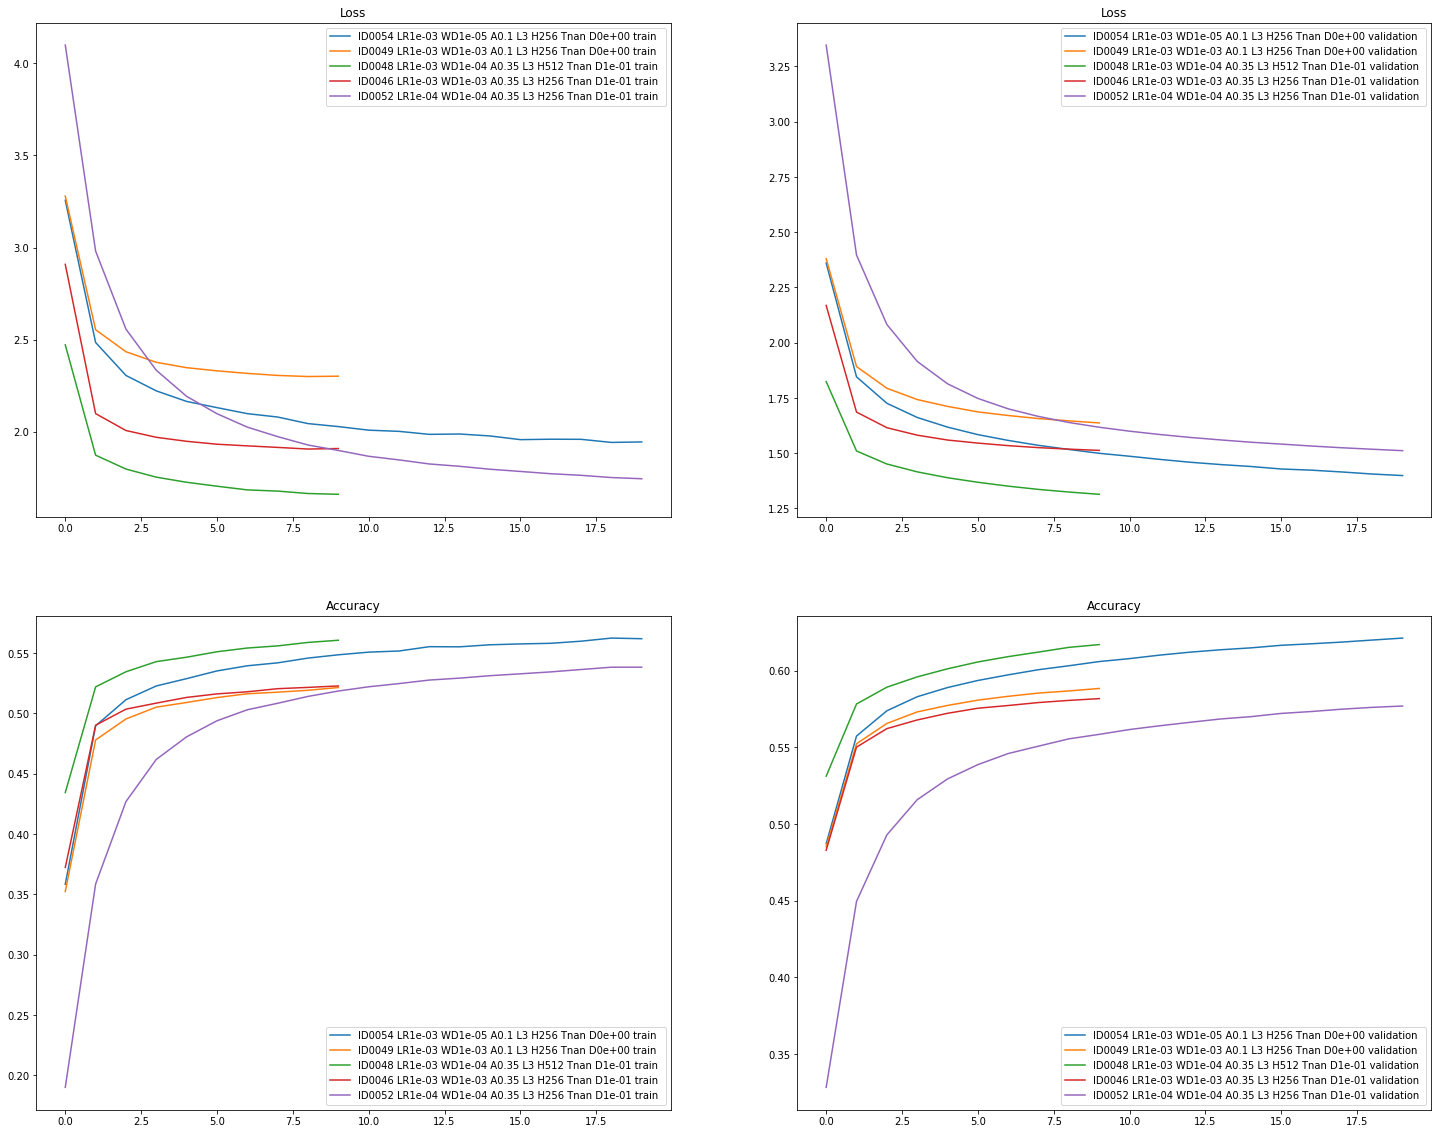

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(25, 20))
max_epoch_plot = 30
for i in ids:
    exp = seml_results.loc[i]
    exp_id = exp["_id"]
    lr = exp["config.train_params.lr"]
    weight_decay = exp["config.train_params.weight_decay"]
    alpha = exp["config.model_params.alpha"]
    nlayers = exp["config.model_params.nlayers"]
    hidden_size = exp["config.model_params.hidden_size"]
    temperature = exp["config.model_params.mean_kwargs.temperature"]
    dropout = exp["config.model_params.dropout"]
    name_suffix = f"ID{i:04d} LR{lr:.0e} WD{weight_decay:.0e} A{alpha:.02} L{nlayers} H{hidden_size:03d} T{temperature:.0e} D{dropout:.0e}"

    epoch_num = exp["config.train_params.max_epochs"]
    val_loss = epoch_mean(exp["result.trace_val.loss"], epoch_num)
    val_acc = epoch_mean(exp["result.trace_val.acc"], epoch_num)
    train_loss = epoch_mean(exp["result.trace_train.loss"], epoch_num)
    train_acc = epoch_mean(exp["result.trace_train.acc"], epoch_num)

    # val_loss = exp["result.trace_val.loss"]
    # val_acc = exp["result.trace_val.acc"]
    # train_loss =exp["result.trace_train.loss"]
    # train_acc = exp["result.trace_train.acc"]
    # max_epoch_plot = 1600 # len(train_loss)

    axs[0, 0].plot(train_loss[:max_epoch_plot], label= f"{name_suffix} train ")
    axs[0, 1].plot(val_loss[:max_epoch_plot], label= f"{name_suffix} validation ")
    axs[1, 0].plot(train_acc[:max_epoch_plot], label= f"{name_suffix} train ")
    axs[1, 1].plot(val_acc[:max_epoch_plot], label= f"{name_suffix} validation ")

axs[0, 0].set_title("Loss")
axs[0, 0].legend(loc="best")
axs[0, 1].set_title("Loss")
axs[0, 1].legend(loc="best")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend(loc="best")
axs[1, 1].set_title("Accuracy")
axs[1, 1].legend(loc="best")
plt.show()

In [ ]:
exp
# _id config.model_params.nlayers  config.model_params.hidden_size config.model_params.mean_kwargs.temperature config.model_params.dropout